In [89]:
import sys
sys.path.append('/Users/hoto7260/Jacob_LIET/LIET/liet')

import rnap_lib_plotting as pt
from liet_res_class import FitParse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from plotnine import *
#import plotting_funcs as pf 
#from plotting_funcs import *
#(didn't work for gene parser due to unrecognized key stringfp)


### Classes
The Gene class is used to hold the information for each gene for any future plotting for a single gene. It also includes the attribute for the FitParse class instance (run).

The Prior class is used to contain the prior posterior information for all genes/instances in whatever loop it is used in. In the script, each prior is named with the "runprior" according to the FitParse instance

In [ ]:
# Create a class for a gene:
class Gene():
    def __init__(self, geneid, annot, fit, log, run):
    # have each gene have its appropriate information from the FitParse class
        self.run = run
        self.geneid = geneid
        self.annot = annot[geneid]
        self.fit = fit[geneid]
        self.strand_cov = log['strand_cov']
        if log['elbo_range']:
            self.elbo_range = log['elbo_range']

# Create a class for the priors
class Prior():
    def __init__(self, name):
        self.name = 'hi'
        self.mean_list = [] # list for all means from post
        self.smean_list = [] # list for all sterror of mean from post
        self.mean_avg = 0
        self.mean_std = 0
        self.smean_avg = 0
        self.smean_std = 0


In [75]:
prior_average = ['mL', "sL", "tI" , "mT", "sT", "w", "mL_a", "sL_a", "w_a"]
prior_post = ['mL', "sL", "tI" , "mT", "sT", "w_LI", 'w_E', 'w_T', 'w_B', "mL_a", "sL_a", "w_aLI", 'w_aB']
prior_average2 = ['mL', "sL", "tI" , "mT", "sT", "mL_a", "sL_a"]

# Set the parameters up for matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family':'serif',
          'axes.titleweight':'bold',
         }
plt.rcParams.update(params)

#======================== Calculations ================================
        
def averager(list1):
    '''This function finds the average of a list of integers.
        - Input: list of integers
        - Returned Output: avg'''
    avg = sum(list1)/len(list1)
    return avg

#======================== Data Collection ================================

def gene_parser(fp, stringfp):
    '''This function parses through & creates a separate Gene class for each gene in the FitParse instance.
        - Input: FitParse instance, string of FitParse instance (stringfp)
        - Unreturned Output: Gene class for each gene w/ all info'''
    for gene, log in fp.log.items():
        if len(log) > 0:
            ((globals()[gene])) = Gene(geneid=gene, annot=fp.annotations,log=log, fit=fp.fits, run=stringfp)
            
def cov_getter(stringfp):
    '''This function retrieves the coverage from the log file of the run & puts in pos & neg coverage lists 
       named with the correct run.
        - Input: string of FitParse instance (stringfp)
        - Unreturned output: stringfp.pos_cov_list & stringfp.neg_cov_list'''
    (globals()[stringfp]).pos_cov_list = []
    (globals()[stringfp]).neg_cov_list = []
    for gene, log in (globals()[stringfp]).log.items():
         if len(log) > 0:
             (globals()[stringfp]).pos_cov_list = (globals()[stringfp]).pos_cov_list + [log['strand_cov'][0]]
             (globals()[stringfp]).neg_cov_list = (globals()[stringfp]).neg_cov_list + [log['strand_cov'][1]]
                
def len_getter(stringfp):
    '''This function retrieves the lengths of each gene from the annotation file of the run and puts them in 
       lists named with the current run
        - Input: string of FitParse instance (stringfp)
        - Unreturned output: stringfp.len_list'''
    (globals()[stringfp]).len_list = []
    for gene, annot in (globals()[stringfp]).annotations.items():
         if len(annot) > 0:
            # both strands have stop being higher number so doesn't matter for length
            length = annot[2] - annot[1] + 1
            (globals()[stringfp]).len_list = (globals()[stringfp]).len_list + [length]
            
    
def prior_meaner(fp, stringfp):
    '''This function finds the average mean & standard error (and appropriate stdev for both) 
       of the posterior distributions of the priors of all genes for the FitParse run & stores 
       the info for each prior in a prior class. 
        - Note: It separates the weights
        - Input: FitParse instance, string of FitParse instance (stringfp)
        - Output: Look at Prior Class'''
    mean_list = []
    smean_list = []
    prior_names = class_namer(stringfp,prior_average)
    prior_names2 = class_namer(stringfp, prior_average2)
    for gene, fit in fp.fits.items():
        for key, key2 in zip(prior_names, prior_average):
            print(key2)
            # separate the value for weights
            if key2=='w_a':
                 # get mean & standard errors of weights from list
                (globals()[str(stringfp+'w_aLI')]).mean_list = ((globals()[str(stringfp+'w_aLI')])).mean_list + [fit[key2][0][0]]
                (globals()[str(stringfp+'w_aLI')]).smean_list = ((globals()[str(stringfp+'w_aLI')])).smean_list + [fit[key2][1][0]]
                (globals()[str(stringfp+'w_aB')]).mean_list = ((globals()[str(stringfp+'w_aB')])).mean_list + [fit[key2][0][1]]
                (globals()[str(stringfp+'w_aB')]).smean_list = ((globals()[str(stringfp+'w_aB')])).smean_list + [fit[key2][1][1]]
            elif key2=='w':
                print(fit[key2])
                # get mean & standard errors of weights from list
                w_list = ['LI', 'E', 'T', 'B']
                windex_list = [0, 1, 2, 3]
                for i, x in zip(w_list, windex_list):
                    (globals()[str(stringfp+'w_'+i)]).mean_list = ((globals()[str(stringfp+'w_'+i)])).mean_list + [fit[key2][0][x]]
                    (globals()[str(stringfp+'w_'+i)]).smean_list = ((globals()[str(stringfp+'w_'+i)])).smean_list + [fit[key2][1][x]]
            else:
                # get the means
                ((globals()[key])).mean_list = ((globals()[key])).mean_list + [fit[key2][0]]
                # get the standard errors
                ((globals()[key])).smean_list = ((globals()[key])).smean_list + [fit[key2][1]]

    
    for key, key2 in zip(prior_names2, prior_average2):
        (globals()[key]).mean_avg = averager(((globals()[key])).mean_list)
        (globals()[key]).smean_avg = averager(((globals()[key])).smean_list)
        (globals()[key]).mean_std == sum([((x - ((globals()[key]).mean_avg)) ** 2) 
                                          for x in ((globals()[key])).mean_list]) / len(((globals()[key])).mean_list)
        (globals()[key]).smean_std == sum([((x - ((globals()[key]).smean_avg)) ** 2) 
                                           for x in ((globals()[key])).smean_list]) / len(((globals()[key])).smean_list)
        

def dataframe_creator(stringfp):
    '''This function creates a dataframe where each gene is a column with labeled rows of all fit information. 
    Note: The priors are based on the class and therefore the weights are separated out too.
    Rows: geneid
    Columns: 
        Annotations: 'chrom', 'start', 'stop', 'strand' 
        Sense Main Priors: 'mL_mean', 'mL_stdev', 'sL_mean','sL_stdev', 'tI_mean', 
                           'tI_stdev', 'mT_mean', 'mT_stdev', 'sT_mean','sT_stdev' 
        Sense Weight Priors:'w_LI_mean', 'w_LI_stdev', 'w_E_mean', 'w_E_stdev',
                            'w_T_mean', 'w_T_stdev', 'w_B_mean', 'w_B_stdev' 
        Antisense Main Priors:'mL_a_mean','mL_a_stdev', 'sL_a_mean', 'sL_a_stdev' 
        Antisense Weight Priors:'w_aLI_mean', 'w_aLI_stdev','w_aB_mean', 'w_aB_stdev'
        Log Info: 'pos_cov', 'nev_cov', 'total_cov', 'elbo_lrange', 'elbo_urange' '''
    # Create a dataframe based on annotations
    (globals()[stringfp]).df = pd.DataFrame(data=(globals()[stringfp]).annotations, 
                                            index=["chrom", "start", "stop", "strand"]).transpose()
    prior_names = class_namer(stringfp,prior_post)
    # Add prior values to the dataframe
    for i, o in zip(prior_names, prior_post):
        (globals()[stringfp]).df[str(o)+'_mean'] = ((globals()[i])).mean_list
        (globals()[stringfp]).df[str(o)+'_stdev'] = ((globals()[i])).smean_list
    # Add the + & - strand coverage, and elbow range
    # initiate lists
    pos_cov_list = []
    neg_cov_list = []
    elbo_lrange_list = []
    elbo_urange_list = []
    # iterate through log items to get values
    for gene, coverage in (globals()[stringfp]).log.items():
        pos_cov_list = pos_cov_list + [coverage['strand_cov'][0]]
        neg_cov_list = neg_cov_list + [abs(coverage['strand_cov'][1])]
        elbo_lrange_list = elbo_lrange_list + [coverage['elbo_range'][0]]
        elbo_urange_list = elbo_urange_list + [coverage['elbo_range'][1]]
    # actually add to dataframe
    (globals()[stringfp]).df['pos_cov'] = pos_cov_list
    (globals()[stringfp]).df['nev_cov'] = neg_cov_list
    (globals()[stringfp]).df['total_cov'] = (globals()[stringfp]).df['pos_cov'] + (globals()[stringfp]).df['nev_cov']
    (globals()[stringfp]).df['elbo_lrange'] = elbo_lrange_list
    (globals()[stringfp]).df['elbo_urange'] = elbo_urange_list
    return (globals()[stringfp]).df

        

    
def dataframe_diff_creator(stringfp1, stringfp2, y_values):
    '''This function will take two dataframes, find the difference between desired 
    variables, & returns a new dataframe with columns of the differences'''
    # Create a new dataframe
    test_df = pd.DataFrame((globals()[stringfp1]).genes, index=(globals()[stringfp1]).genes )
    # Get the differences & add to data frame
    for y_value in y_values: 
#         if 'w' in y_value:
            
        test_df[y_value] = (globals()[stringfp1]).df[y_value]-(globals()[stringfp2]).df[y_value]
    # Get the averages of the fit_coverage
    return test_df
    

#======================== Naming ================================
    
def prior_namer(stringfp):
    '''This function makes each prior a class instance of Prior with a name of the run + prior.
        - Input: string of FitParse instance (stringfp)
        - Unreturned output: stringfpprior as a Prior class instance'''
    prior_names = [str(stringfp + x) for x in prior_post]
    for prior in prior_names:
        print(prior)
        ((globals()[prior])) = Prior(name=prior)

def class_namer(classstring, name):
    '''This function makes the items in name (can be list or string) be attached to the classname 
       to make a new name --> classname.name
        - Input: classstring, name (list or string)
        - Returned output: newname (list or string)'''
    #check if name is a list or not
    if len(name):
        newname = [str(classstring + x) for x in name]
    else: 
        newname = str(classstring+name)
    return newname

#======================== Plotting (1 run) ================================

                
def cov_std_plotter(stringfp):
    '''This function plots the standard deviation of the posterior distribution of each prior 
       against the positive & negative strand coverages.
        - Input: string of FitParse instance (stringfp)
        - Output: labeled graphs as described above'''
    prior_list = class_namer(stringfp, prior_average2)
    xlim = max((globals()[stringfp]).pos_cov_list)/2.5
    # Graph the pos strand coverage vs std
    for i in prior_list:
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot()
        ax.scatter((globals()[stringfp]).pos_cov_list, (globals()[i]).smean_list, color='red')
        plt.ylabel(str("standard deviation of "+ str(i)))
        plt.xlabel("positive strand coverage (rds/kb)")
        xlabel = str(i).replace(str(stringfp), '')
        plt.xlim([0, xlim]) 
        plt.title(str("Standard deviation of posterior distribution of "+str(xlabel)+
                      " vs positive strand coverage in "+str(stringfp)))
    # Graph the neg strand coverage vs std
    for i in prior_list:
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot()
        ax.scatter((globals()[stringfp]).neg_cov_list, (globals()[i]).smean_list, color='blue')
        plt.ylabel(str("standard deviation of "+ str(i)))
        plt.xlabel("negative strand coverage (rds/kb)")
        xlabel = str(i).replace(str(stringfp), '')
        plt.title(str("Standard deviation of posterior distribution of "+str(xlabel)+
                      " vs negative strand coverage in "+str(stringfp)))

      
    
def len_std_plotter(stringfp):
    prior_list = class_namer(stringfp, prior_average2)
    # Graph the length vs std
    for i in prior_list:
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot()
        ax.scatter((globals()[stringfp]).len_list, (globals()[i]).smean_list, color='green')
        plt.ylabel(str("standard deviation of "+ str(i)))
        plt.xlabel("lengths of genes (bp)")
        xlabel = str(i).replace(str(stringfp), '')
        plt.title(str("Standard deviation of posterior distribution of "+str(xlabel)+
                      " vs gene lengths in "+str(stringfp)), fontweight = 'bold')

def dataframe_single_plotter(stringfp_df, stringfp, y_values, log=False, sort=True):
    '''This function plots a histogram for the values in y_values (list). It can also color code by coverage.'''
    for y_value in y_values:
        fig = plt.figure()
        ax = fig.add_subplot()
        if sort==True:
            stringfp_df = stringfp_df.sort_values(by=[y_value], ascending=False)
        if log==True:
            ax.hist(stringfp_df[y_value], bins=len(stringfp_df[y_value]/1.3), orientation='vertical', log=True, color=None)
            ax.set(title=str('log('+y_value +')'+' for '+ stringfp))
        else:   
            ax.hist(stringfp_df[y_value], bins=len(stringfp_df[y_value]/1.3), orientation='vertical', log=False, color=None)
            ax.set(title=str(y_value +' for '+ stringfp))
        
def dataframe_single_comp_plotter(stringfp_df, stringfp, y_values, corr='pearson', cover=False):
    '''This function plots the y_values (list) against each other. It also shows the 
    LINEAR correlation (Pearson's R^2) between the 2 if corr=True'''

    # iterate through to plot y_values of against each other
    for x in range(0, len(y_values)-1):
        fig = plt.figure()
        ax = fig.add_subplot()
        if cover==True:
            # add color coding by coverage
            print('hi')
            #ax.scatter(stringfp_df[y_values[x]], (stringfp_df[y_values[x+1]], c=(stringfp_df['total_cov']), cmap='gray')
        else: 
            ax.scatter(stringfp_df[y_values[x]], stringfp_df[y_values[x+1]])
        ax.set(ylabel=str(y_values[x+1]), 
                xlabel=str(y_values[x]),
                title=str(y_values[x] + ' and ' + y_values[x+1] + ' for ' + stringfp))
        if corr=='pearson':
            # calculate Pearson's correlation
            corr_value, _ = pearsonr(stringfp_df[y_values[x]], stringfp_df[y_values[x+1]])
        elif corr=='spearman':
            # calculate Spearman's correlation
            corr_value, _ = spearmanr(stringfp_df[y_values[x]], stringfp_df[y_values[x+1]])  
            ax.set(title=str(y_values[x] + ' and ' + y_values[x+1] + ' for ' 
                             + str(stringfp + '(R^2: ' + str(round(corr_value, 4)) + ')')))



#======================== Plotting (more than 1 run) ================================
def dataframe_compare_plotter(stringfp1, stringfp2, y_values, corr=True, cover=True):
    '''This function plots the y_values (list) between each of the runs (stringfp1 & stringfp2). It also shows the 
    LINEAR correlation (Pearson's R^2) between the 2 if corr=True'''
    # only compare where have same genes
    # ensure the same length as proxy for same genes
    assert (len((globals()[stringfp1]).df)==len((globals()[stringfp2]).df))
        # plot y_value of both runs against each other
    count = -1
    for y_value in y_values: 
        count = count + 1
        # if count is even or 0 then subplot 1 & make new fig and if odd then subplot 2
        if (count % 2) == 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
            if cover==True:
                ax1.scatter((globals()[stringfp1]).df[y_value], (globals()[stringfp2]).df[y_value], c=(globals()[stringfp1]).df['total_cov'], cmap='gray', label=(globals()[stringfp1]).df['total_cov'])
            else: 
                ax1.scatter((globals()[stringfp1]).df[y_value], (globals()[stringfp2]).df[y_value])
            ax1.set(ylabel=str(y_value + ' of ' + stringfp2), 
                    xlabel=str(y_value + ' of ' + stringfp1),
                   title=str(y_value + ' for each gene of ' + stringfp1 + ' and ' + stringfp2))
            #ax1.legend()
        else:
            ax2.scatter((globals()[stringfp1]).df[y_value], (globals()[stringfp2]).df[y_value])
            ax2.set(ylabel=str(y_value + ' of ' + stringfp2), 
                    xlabel=str(y_value + ' of ' + stringfp1),
                   title=str(y_value + ' for each gene of ' + stringfp1 + ' and ' + stringfp2))
        if corr==True:
            # calculate Pearson's correlation
            corr_value, _ = pearsonr((globals()[stringfp1]).df[y_value], (globals()[stringfp2]).df[y_value])  
            if (count % 2) == 0:
                ax1.set(title=str(y_value + ' for each gene of ' + stringfp1 
                                  + ' and ' + stringfp2 + '(R^2: ' + str(round(corr_value, 4)) + ')'))
            else: 
                ax2.set(title=str(y_value + ' for each gene of ' + stringfp1 
                                  + ' and ' + stringfp2 + '(R^2: ' + str(round(corr_value, 4)) + ')'))

            
def dataframe_diff_plotter(df, y_values, stringfp1, stringfp2, all=False, fixed=False, fixed_vals={}, max_val=4, cover=True):
    '''This function takes a dataframe with differences and plots the desired y_values. It allows you to truncate which
    genes to show according to how different they are (if all is not True, it will only graph those genes with differences
    greater than the max difference value divided by user's max_val).
    Inputs: df=diff_dataframe, y_values=list of desired differecnes to plot, the two runs in string form (ordered same as 
    dataframe_diff_creator(), all default is False, max_val=integer), cov=float by which you want to highlight bad coverage'''
    # make a bar_chart for the values for each gene
    if fixed_vals=={}:
        fixed_vals = y_values
    for y, cutoff in zip(y_values, fixed_vals):
        df = df.sort_values(y)
        if all==True:
            df2 = df
            df2.plot(x=0, y=y, kind="bar",
                     xlabel='gene', ylabel='difference',
                    title=str('Differences of '+stringfp1+'-'+stringfp2+ ' for '+y))
        elif fixed==True:
            df2 = df.loc[abs(df[y]) > cutoff] 
            print(y, len(df2))
            df2.plot(x=0, y=y, kind="bar",
                     xlabel='gene', ylabel='difference',
                    title=str('Differences of '+stringfp1+'-'+stringfp2+ ' for '+y+'with cut off of '+ str(cutoff)))
        else:
            print(max(df[y]))
            value = max(df[y])/max_val
            df2 = df.loc[abs(df[y]) > value]
            df2.plot(x=0, y=y, kind="bar",
                     xlabel='gene', ylabel='difference',
                    title=str('Differences of '+stringfp1+'-'+stringfp2+ ' for '
                              +y+'with cut off of max_val/'+str(max_val)+' ('+str(value)+')'))
    # Say which genes are found among all of the plots?
    

    # Color code by fit_coverage 


## Using the FitParse class to get results from results & log file
Initiating the class produces three results:
1. List of genes: .genes
    - just geneids
2. Ordered dictionary of annotations: .annotations
    - geneid: chrom, start, stop, strand
3. Ordered dictionary of fits: .fits
    - gene id: {prior: (mean, standard error from posterior dist)}
4. Ordered dictionary of log:
    - gene id: {strand_cov: cov_pos, cov_neg, elbo_range: coord, coord}

In [1]:
# initiate FitParse class instance with SRR12083664 that did not include mL_a
     # from 9.2
log_file = "/Users/hoto7260/batch_out_files/LIETfirstSRRtests/LIETtest_run9.2/SRR12083664.10ksamp2_2_Hope_nomLab.liet.log"
res_file = "/Users/hoto7260/batch_out_files/LIETfirstSRRtests/LIETtest_run9.2/SRR12083664.10ksamp2_2_Hope_nomLab.liet"
srr3664_no = FitParse(res_file=res_file, log_file=log_file)


NameError: name 'FitParse' is not defined

## Getting the data into appropriate Prior classes

In [ ]:
# Make each prior its own Prior class instance with the name srr3664prior
prior_namer("srr3664_no")
# Have the Prior class instances each have the means & standard deviations needed for graphing and the Gene instances have their appropriate info
prior_meaner(srr3664_no, "srr3664_no")
prior_post = ['mL', "sL", "tI" , "mT", "sT", "w_LI", 'w_E', 'w_T', 'w_B', "mL_a", "sL_a", "w_aLI", 'w_aB']

## Getting all data into a dataframe

In [39]:
srr3664_no.df = dataframe_creator("srr3664_no")
# dataframe_creator("srr3664_yes2")
# dataframe_creator("srr3664_no")
# Index(['chrom', 'start', 'stop', 'strand', 'mL_mean', 'mL_stdev', 'sL_mean',
#        'sL_stdev', 'tI_mean', 'tI_stdev', 'mT_mean', 'mT_stdev', 'sT_mean',
#        'sT_stdev', 'w_mean', 'w_stdev', 'mL_a_mean', 'mL_a_stdev', 'sL_a_mean',
#        'sL_a_stdev', 'w_a_mean', 'w_a_stdev', 'pos_cov', 'nev_cov',
#        'total_cov', 'elbo_lrange', 'elbo_urange'],
#       dtype='object')

Index(['chrom', 'start', 'stop', 'strand', 'mL_mean', 'mL_stdev', 'sL_mean',
       'sL_stdev', 'tI_mean', 'tI_stdev', 'mT_mean', 'mT_stdev', 'sT_mean',
       'sT_stdev', 'w_LI_mean', 'w_LI_stdev', 'w_E_mean', 'w_E_stdev',
       'w_T_mean', 'w_T_stdev', 'w_B_mean', 'w_B_stdev', 'mL_a_mean',
       'mL_a_stdev', 'sL_a_mean', 'sL_a_stdev', 'w_aLI_mean', 'w_aLI_stdev',
       'w_aB_mean', 'w_aB_stdev'],
      dtype='object')


## 1. Filtering through reads to only get ones with appropriate antisense coverrage
1. All genes with 0 coverage should have been removed

#### Remove genes with high background weight
1. Make histograms of w_B & w_a_B

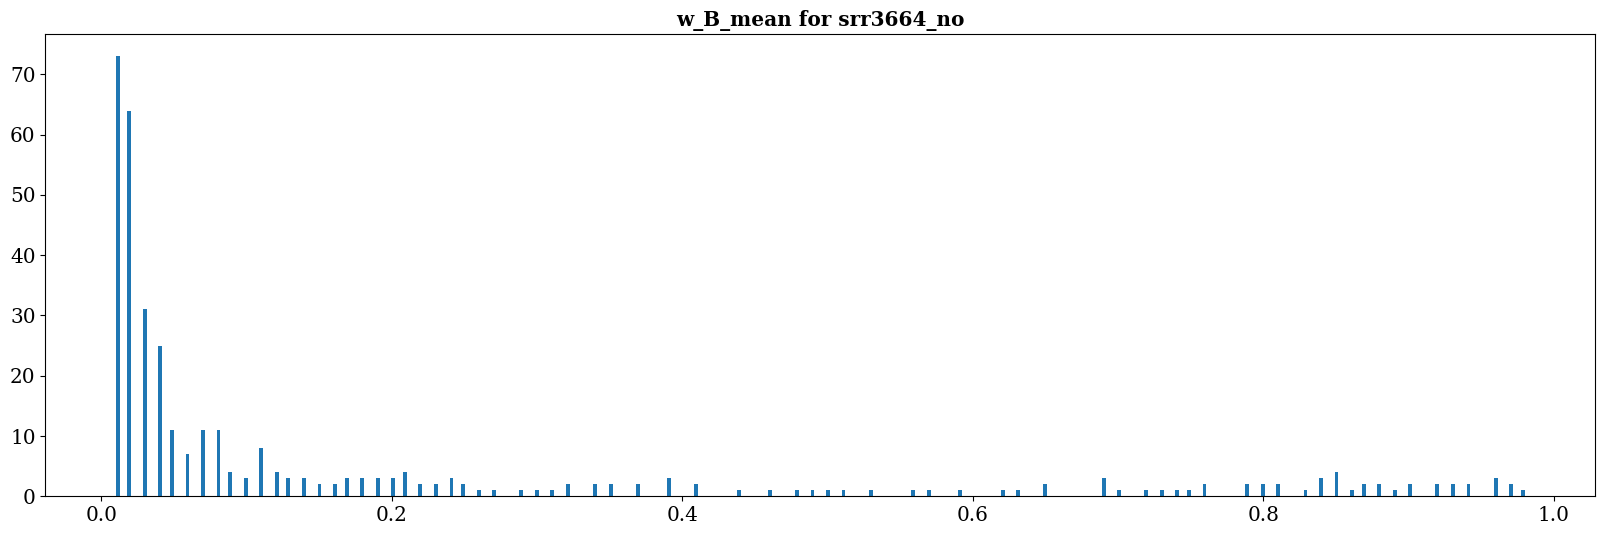

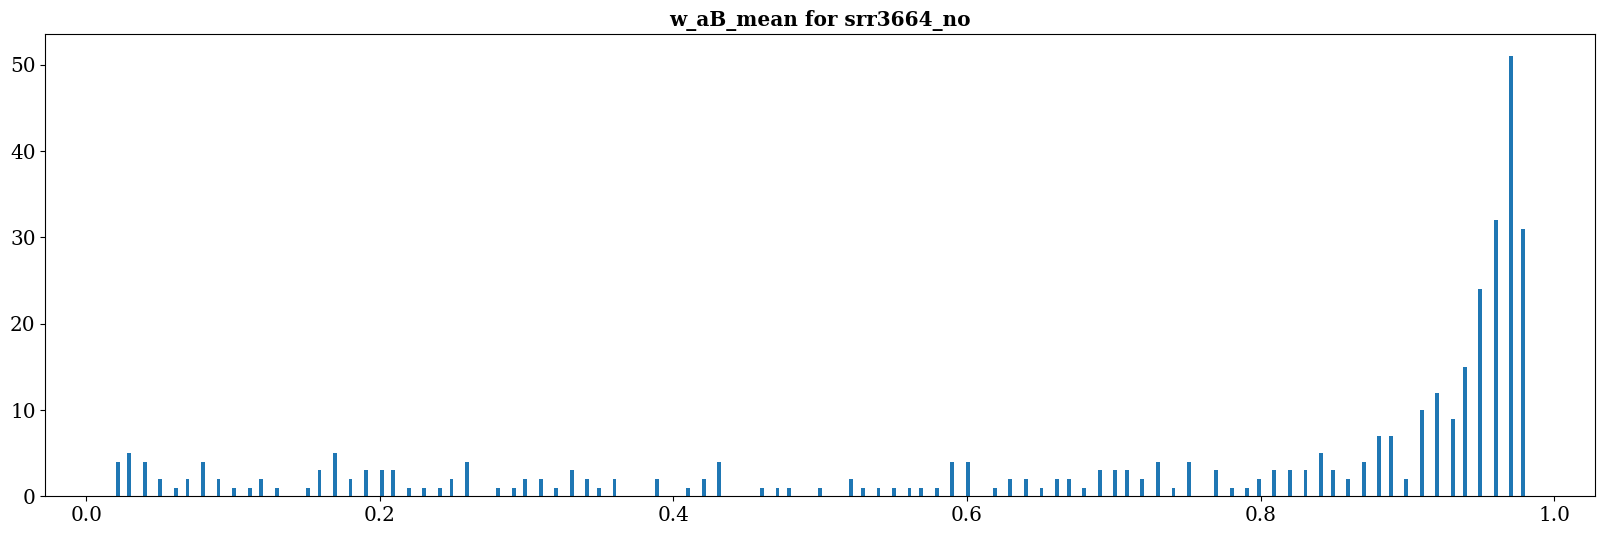

In [51]:
y_values = ['w_B_mean', 'w_aB_mean']
dataframe_single_plotter(srr3664_no.df, 'srr3664_no',y_values, cover=False, sort=True)

2. Make histograms of w_B sense cov (pos_cov * w_B) and w_a_B antisense cov (neg_cov * w_a_B)

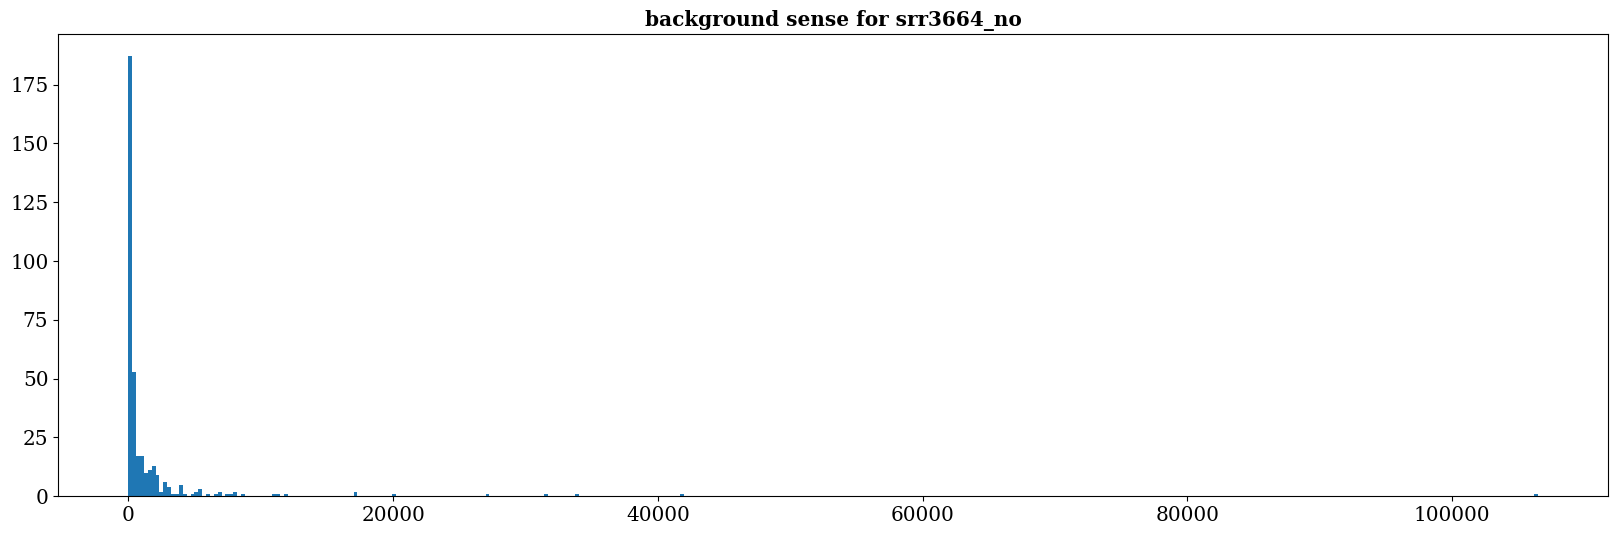

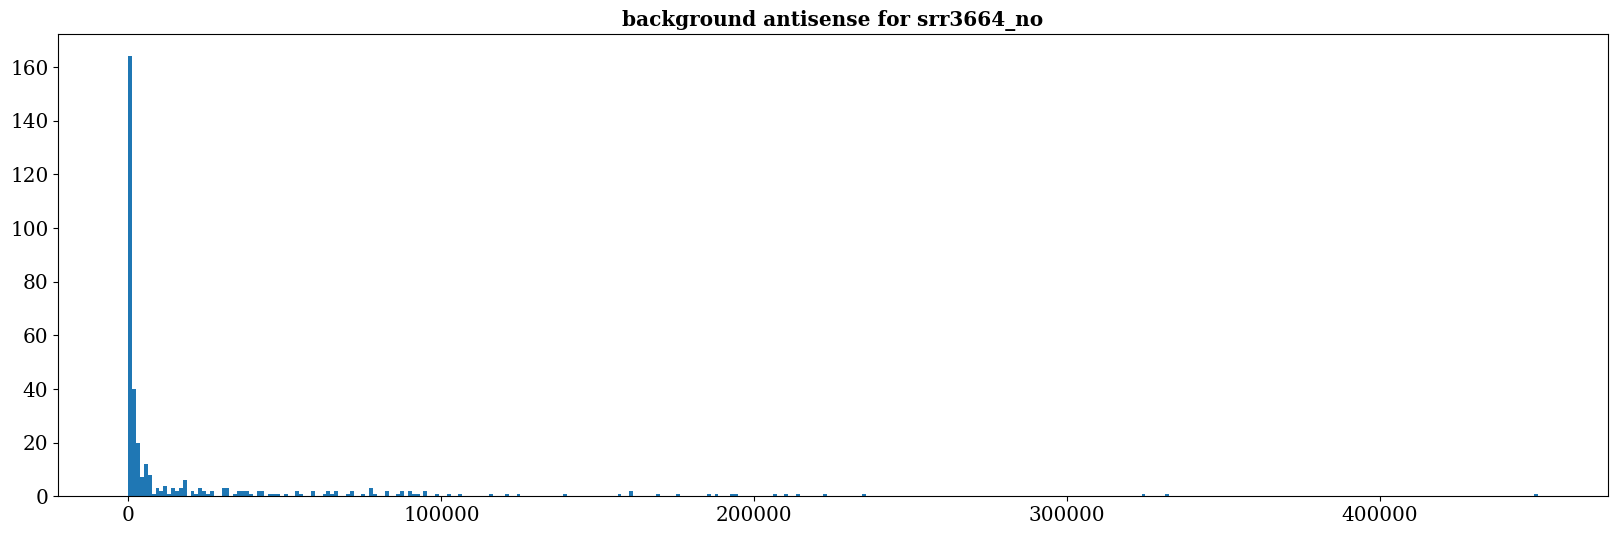

In [83]:
srr3664_no.df['background sense'] = srr3664_no.df['w_B_mean']*srr3664_no.df['pos_cov']
srr3664_no.df['background antisense'] = srr3664_no.df['w_aB_mean']*srr3664_no.df['pos_cov']
y_values = ['background sense', 'background antisense']
dataframe_single_plotter(srr3664_no.df, 'srr3664_no',y_values, sort=True, log=False)

3. Filter based on the above findings
In this case, it seems like the values temper off around a value of wB =0.12 and a value of wa_B of around 0.88.
Therefore, I'm going to filter based on values having to have antisense background lower than 0.88 and sense background lower than 0.12 and see if the second set of graphs changes significantly.

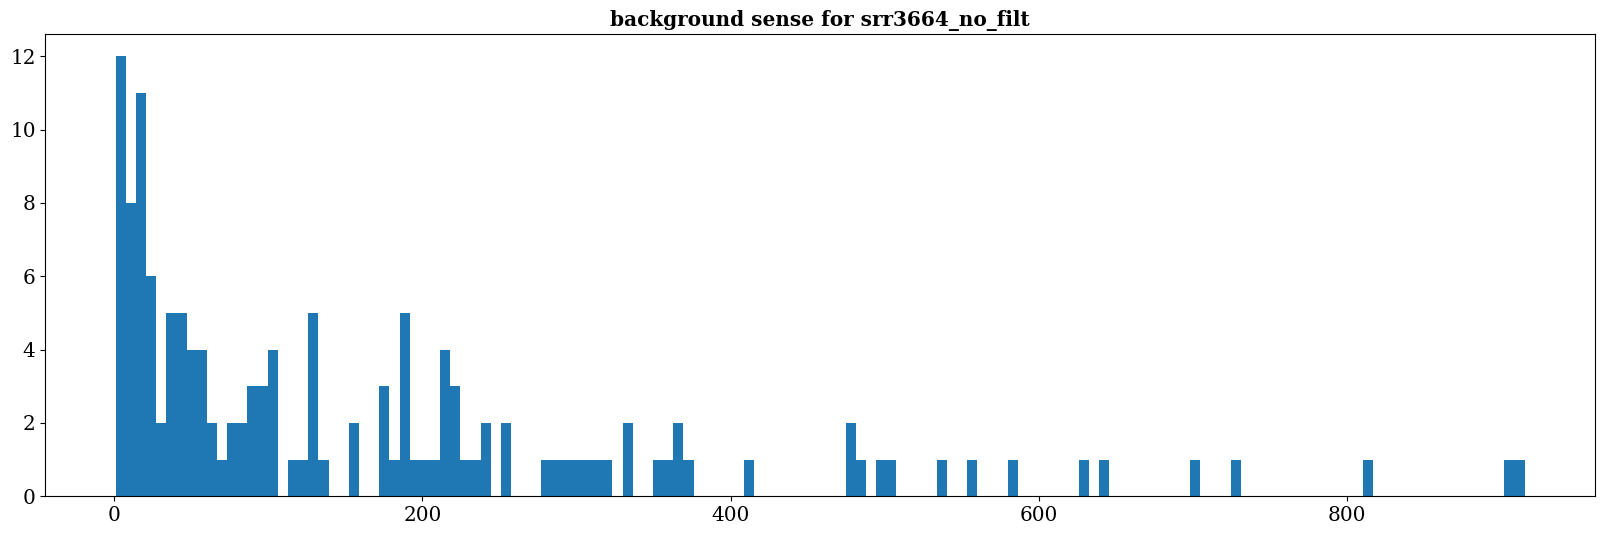

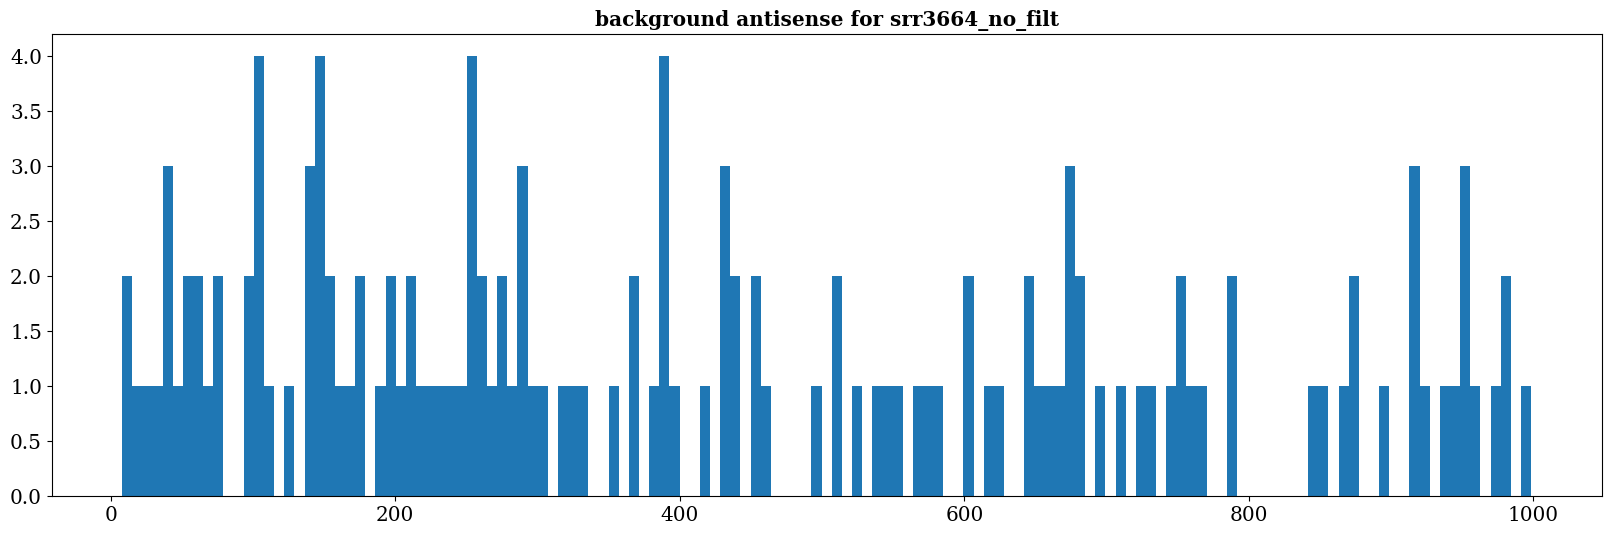

In [85]:
# filtsrr3664_no_df = srr3664_no.df.loc[abs(srr3664_no.df['w_aB_mean']) >0.88] 
# filtsrr3664_no_df = filtsrr3664_no_df.loc[abs(filtsrr3664_no_df['w_B_mean']) <0.12] 
filtsrr3664_no_df = srr3664_no.df.loc[abs(srr3664_no.df['background sense']) <1000] 
filtsrr3664_no_df = filtsrr3664_no_df.loc[abs(filtsrr3664_no_df['background antisense']) <1000] 
y_values = ['background sense', 'background antisense']
dataframe_single_plotter(filtsrr3664_no_df, 'srr3664_no_filt',y_values, sort=True, log=False)

## 2. Determine if termination peaks correlate with antisense initiation peaks
1. Multiply neg coverage by w_a_LI to get model's estimation of antisense transcription
2. Multiply pos coverage by w_T to get model's estimation of termination transcription
3. Plot both against each other

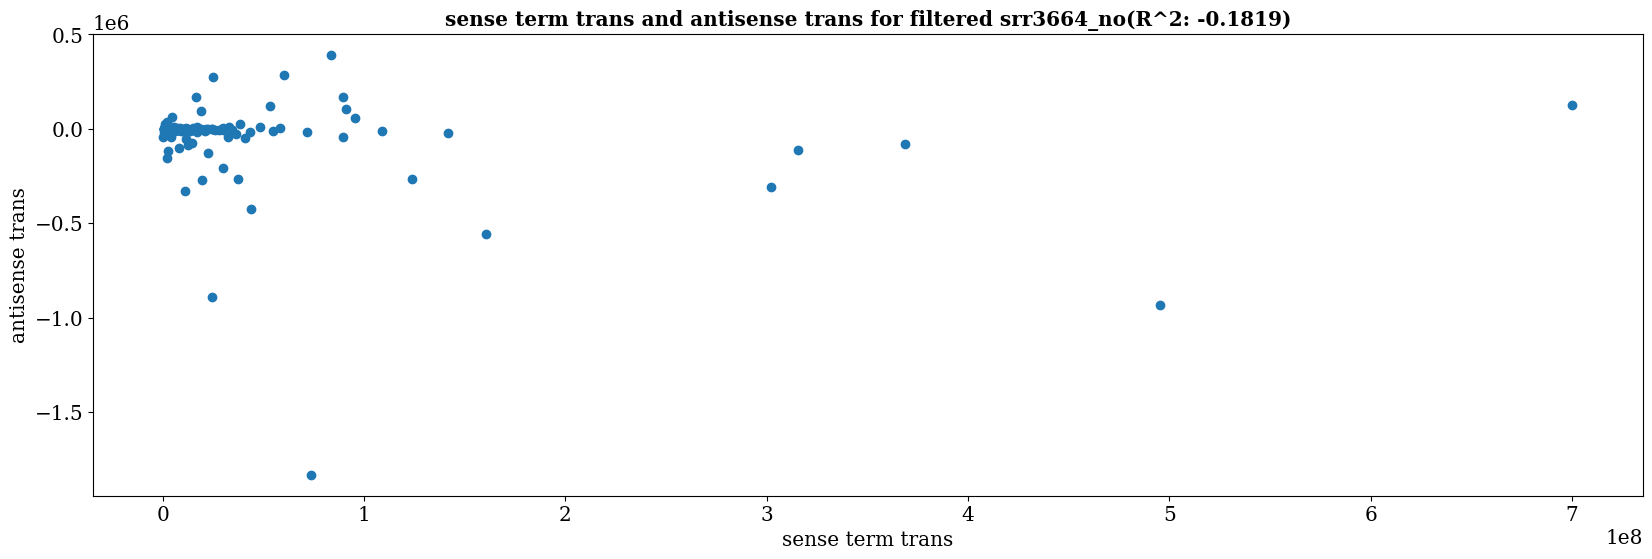

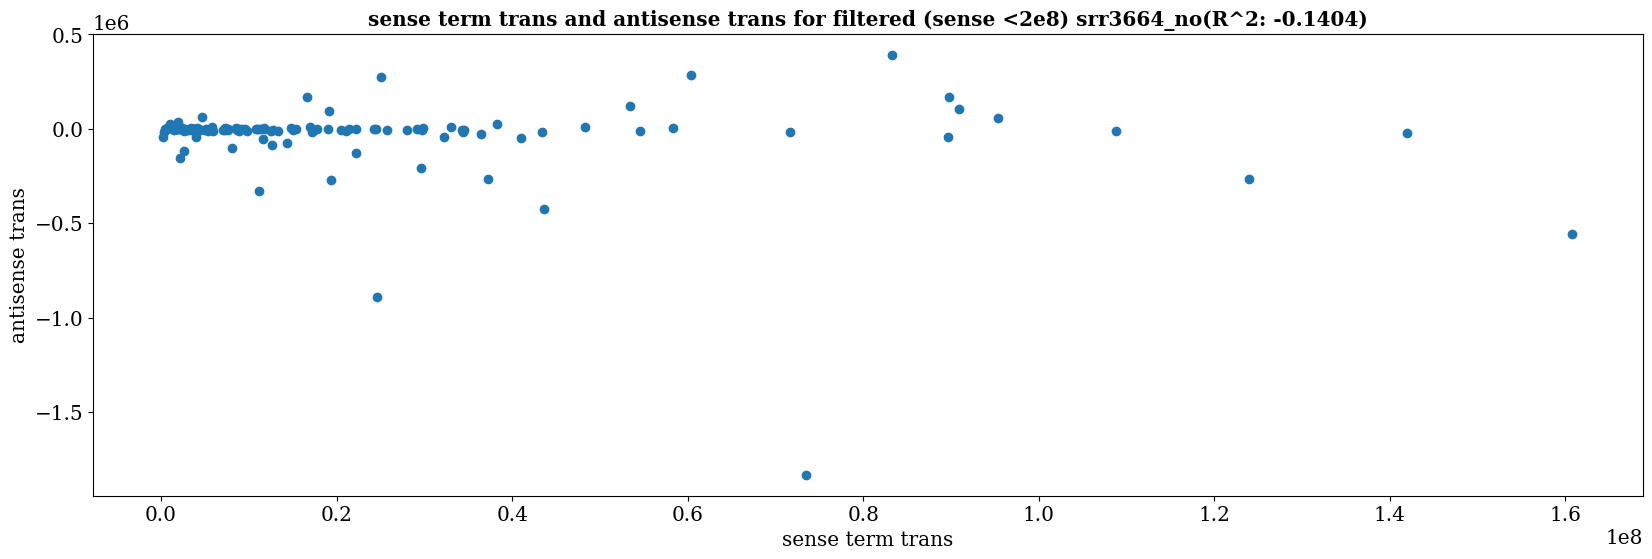

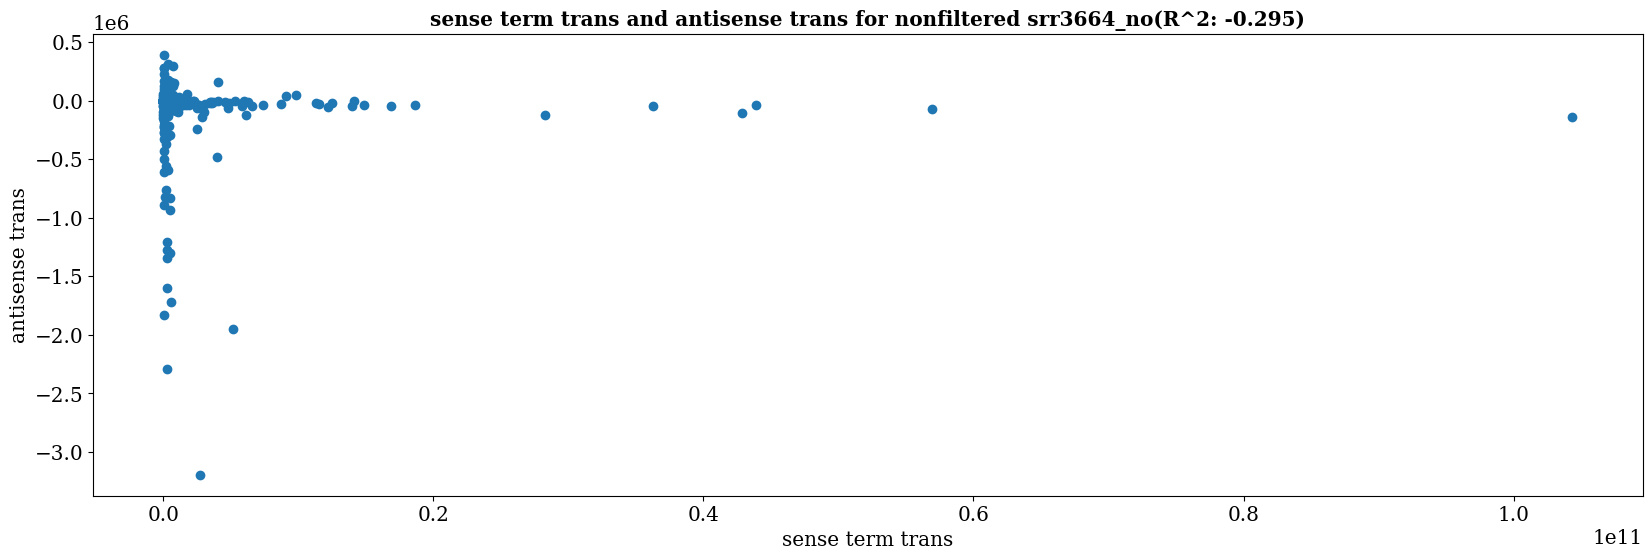

In [105]:
# Estimate antisense transcription
filtsrr3664_no_df['antisense trans'] = filtsrr3664_no_df['mL_a_mean']*filtsrr3664_no_df['nev_cov']
# Estimate sense termination transcription
filtsrr3664_no_df['sense term trans'] = filtsrr3664_no_df['mT_mean']*filtsrr3664_no_df['pos_cov']
# Plot both against each other
y_values = ['sense term trans','antisense trans']
dataframe_single_comp_plotter(filtsrr3664_no_df, 'filtered srr3664_no', y_values, corr='spearman', cover=False)
## Truncate the outliers
filt2srr3664_no_df =filtsrr3664_no_df.loc[filtsrr3664_no_df['sense term trans']<2e8]
dataframe_single_comp_plotter(filt2srr3664_no_df, 'filtered (sense <2e8) srr3664_no', y_values, corr='spearman', cover=False)

# Estimate antisense transcription
srr3664_no.df['antisense trans'] = srr3664_no.df['mL_a_mean']*srr3664_no.df['nev_cov']
# Estimate sense termination transcription
srr3664_no.df['sense term trans'] = srr3664_no.df['mT_mean']*srr3664_no.df['pos_cov']
# Plot both against each other
y_values = ['sense term trans','antisense trans']


dataframe_single_comp_plotter(srr3664_no.df, 'nonfiltered srr3664_no', y_values, corr='spearman', cover=False)